In [1]:
import os
import re
import glob
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import seaborn as sns

## 1. Functions

In [4]:
def get_data_infos(data_from):
    '''
    <returns>:
        n_trials   : sequence length
        n_repeat   : number of repetitions per block 
        n_blocks   : number of blocks per sequence type
        section_len: number of trials per section
    '''
    if data_from == "Joanne": 
        n_trials = 8 
        n_repeat = 5 
        n_blocks = 7 
        block_size = n_trials * n_repeat * 2
            # each block includes the same amount of random trials
        section_len = block_size * n_blocks
            # two sections
        
    elif data_from == "BinShan": 
        n_trials = 12
        n_repeat = 8 
        n_blocks = 13
        block_size = 5 + n_trials * n_repeat
            # each block includes five random trials
        section_len = block_size * (n_blocks + 3)
            # one section, with three random blocks
        
    return n_trials, n_repeat, n_blocks, block_size, section_len

In [24]:
def proc_data(data_all, data_from, stim_list, seqlearn_rows=None):
    
    if data_from == "Joanne":
        
        data_all = data_all.query("Block != 'R'")
        data_all.loc[:, "Target"] = data_all["Target"].replace(
            { n+1: stim for n, stim in enumerate(stim_list) }
        )
        data_all.loc[:, "Response"] = data_all["Response"].replace(
            { n+5: stim for n, stim in enumerate(stim_list) }
        )
        seqlearn_rows = [ x for x in data_all.index if x in seqlearn_rows ]
        data_seqlearn = data_all.loc[seqlearn_rows, :]      

        RT_ref_dict = {} # baseline RT 
        for b in set(data_seqlearn["Block"]):
            globals()["b"] = b
            RT_ref_dict[b] = {
                s: data_all.query("State == 'R' & " + 
                                  "Block == @b & " + 
                                  "Response == @s & " + 
                                  "Hit == 1"
                )["RT"] for s in stim_list
            }
        
    elif data_from == "BinShan":
        
        data_all = data_all.iloc[:, :6].query("Block not in [0, 1]")
        data_all.loc[:, "Target"] = data_all["Target"].replace(
            { n+1: stim for n, stim in enumerate(stim_list) }
        )
        data_all.loc[:, "Response"] = data_all["Response"].replace(
            { n+1: stim for n, stim in enumerate(stim_list) }
        )
        data_seqlearn = data_all.query("State == 'Sequential' & Hit == 1")
        
        RT_ref_dict = {} 
        for b in set(data_seqlearn["Block"]): 
            globals()["b"] = b-1
            
            if b < 6:               # 2, 3, 4, 5
                globals()["b"] = 6  # random block
            elif b < 11:            # 7, 8, 9, 10
                globals()["b"] = 11 # random block
            else:                   # 12, 13, 14, 15, 17
                globals()["b"] = 16 # random block
                
            RT_ref_dict[b] = {
                s: data_all.query("Block == @b & " + 
                                  "Response == @s & " + 
                                  "Hit == 1"
                )["RT"] for s in stim_list
            }
    
    data_copy = data_seqlearn.copy()
    data_copy.loc[:, "RT_imp"] = data_copy.apply( # RT improvements
        lambda x: RT_ref_dict[x["Block"]][x["Target"]].mean() - x["RT"], 
        axis=1
    )
    data_seqlearn = data_copy.copy()
        
    return data_all, data_seqlearn

In [6]:
def gen_pattern_list(stim_list, pattern_size):
    return [ 
        "".join(P) for P in np.array(
            np.meshgrid(* [stim_list] * pattern_size)
        ).T.reshape(-1, pattern_size)
    ]

In [7]:
def compute_trans_mat(stim_list, pattern_size, obsverations): 
    '''
    <return> 
        A matrix of p(xi | xj) whose columns represent the given pattern (xj)
        and rows represent the upcoming stimulus (xi).
    '''
    if len(obsverations) >= pattern_size: 
        return pd.DataFrame.from_dict({
            xj: {
                xi: (( 
                    len(re.findall(f"{xj}{xi}", "".join(obsverations))) 
                    + 1 
                ) / ( 
                    len(re.findall(f"{xj}", "".join(obsverations[:-1])))
                    + len(stim_list)
                )) for xi in stim_list
            } for xj in gen_pattern_list(stim_list, pattern_size - 1)
        })
    else:
        return pd.DataFrame( # a uniform distribution
            1 / len(stim_list), 
            index = stim_list, 
            columns = gen_pattern_list(stim_list, pattern_size - 1), 
        ) 

### 1.1 Functions for computing information theoretic indices 
see: https://ideazaurus.com/posts/general/information_theory.html

In [8]:
def compute_self_information(p_xi):
    '''   
    The bits of information we receive from observing the event xi.
    Can also be stated as surprisal.
    
    <Symbolic Expression>: H[E(x) == xi]
    
    <Input> 
        p_xi (float): the probability of event xi.
    '''
    return -1 * np.log2(p_xi)

In [9]:
def compute_entropy(p_x):
    '''
    Shannon's approach to quantify uncertainty of random variable x.
    
    <Symbolic Expression>: H[E(x)]
    
    <Input> 
        p_x (array): the marginal distribution of x, summing to one.
    '''
    return np.nansum(-1 * p_x * np.log2(p_x))

In [10]:
def compute_conditional_entropy(p_xy_joint, p_y, p_x):
    '''
    The information contained in x given y.
    Equal to the total amount of uncertainty associated with x and y ...
    ... minus the amount of uncertainty already contained in y. 
    
    <Symbolic Expression>: H[E(x) | E(y)] 
        = H[E(x), E(y)] - H[E(y)]
    
    <Input> 
        p_xy_joint (array): the probability distribution of event pairs.
    '''
    p_x_given_y = p_xy_joint / p_y
    return np.nansum(-1 * p_xy_joint * np.log2(p_x_given_y))

In [11]:
def compute_mutual_information(p_xy_joint, p_y, p_x):
    '''
    The average amount of surprisal by seeing two outcomes happening together
        compared to what we would expect if they were independent.
        
    <Symbolic Expression>: I[E(x); E(y)] 
        = H[E(x), E(y)] - H[E(x) | E(y)] - H[E(y) | E(x)]
        = H[E(x), E(y)] - H[E(x), E(y)] + H[E(y)] - H[E(x), E(y)] + H[E(x)] 
        = H[E(y)] + H[E(x)] - H[E(x), E(y)] 
    '''
    return np.nansum(p_xy_joint * np.log2(p_xy_joint / (p_y * p_x)))

In [12]:
def compute_information_gain(p_xiyi_joint, p_yi, p_xi):
    '''
    The reduction in uncertainty about xi after observing yi.
    Equalvent to surprisal reduction.
    
    <Symbolic Expression>: IG[E(x) == xi; E(y) == yi] 
        = H[E(x) == xi] - H[E(x) == xi | E(y) == yi]
        = H[E(x) == xi] + H[E(y) == yi] - H[E(x) == xi, E(y) == yi]
    '''
    return np.log2(p_xiyi_joint / (p_yi * p_xi))

In [13]:
def compute_IT_indices(stim_list, pattern_size, stim_stream):
    
    pattern_list = gen_pattern_list(stim_list, pattern_size)
    prev_list = gen_pattern_list(stim_list, pattern_size - 1)
    
    track_surprisal    = []
    track_entropy      = [] 
    track_cond_entropy = []
    track_mutual_info  = []
    track_sp_reduction = []
    
    for t in range(1, len(stim_stream)+1):
        observations = stim_stream[0:t] 
        obs_string = "".join(observations)        
        pattern_count = len(observations) - pattern_size + 1
        
        if pattern_count < 1: 
            p_xi = 1 / len(stim_list)
            marg_dist_curr = np.array( [p_xi] * len(stim_list) )
            p_xj = 1 / len(prev_list)
            marg_dist_prev = np.array([p_xj] * len(prev_list))
            p_xjxi = 1 / len(pattern_list)
            [p_joint, p_x_prev, p_x_curr] = np.array(
                [p_xjxi, p_xj, p_xi] * len(pattern_list) 
            ).reshape(-1, 3).T
            
        else: 
            marg_dist_curr = np.array([ # marginal distribution
                ( (observations.count(x) + 1) / 
                  (len(observations) + len(stim_list)) )
                for x in stim_list
            ]) 
            
            xi = obs_string[-1] # the current stimulus     
            p_xi = dict(zip(stim_list, marg_dist_curr))[xi]
            
            marg_dist_prev = np.array([
                ( (len(re.findall(prev, obs_string[:-1])) + 1) / 
                  (pattern_count + len(prev_list)) )
                for prev in prev_list
            ])
            
            xj = obs_string[-pattern_size:-1]  # the obsvered stimuli 
            p_xj = dict(zip(prev_list, marg_dist_prev))[xj]
        
            [p_joint, p_x_prev, p_x_curr] = np.array([ [
                (( len(re.findall(P, obs_string)) + 1 ) / 
                 ( pattern_count + len(pattern_list) )), 
                (( len(re.findall(P[:-1], obs_string[:-1])) + 1 ) / 
                 ( pattern_count + len(prev_list) )), 
                (( observations.count(P[-1]) + 1 ) / 
                 ( len(observations) + len(stim_list) )) 
            ] for P in pattern_list ]).T
            
            xjxi = obs_string[-pattern_size::] # the current pattern
            p_xjxi = dict(zip(pattern_list, p_joint))[f"{xj}{xi}"]
            
        # Shannon entropy:
        track_entropy.append(compute_entropy(p_joint))

        # Surprisal:        
        track_surprisal.append(
            compute_self_information(p_xjxi))

        # Conditional Entropy:
        track_cond_entropy.append( 
            compute_conditional_entropy(p_joint, p_x_prev, p_x_curr))

        # Mutual Information:
        track_mutual_info.append( 
            compute_mutual_information(p_joint, p_x_prev, p_x_curr))

        ## Surprisal Reduction:
        track_sp_reduction.append( 
            compute_information_gain(p_xjxi, p_xj, p_xi))

    return (track_surprisal, 
            track_entropy, 
            track_cond_entropy, 
            track_mutual_info, 
            track_sp_reduction)

### 1.2 Functions for plotting

In [14]:
def plot_transition_mat(trans_mat, fig_size=(3, 3), show_dat=True, 
                        c_map=["Reds", "rocket_r", "flare"][0], 
                        v_min=None, v_max=None):

    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot()
    sns.heatmap(
        trans_mat, 
        annot=show_dat, fmt=".2f", 
        cmap=c_map, vmin=v_min, vmax=v_max, 
        cbar_kws={'shrink': 0.6}, 
        linewidth=.5, square=True, 
    )
    ax.set_xticks(
        np.arange(0, trans_mat.shape[1], 1) + .5,  
        labels=trans_mat.columns, 
        rotation=90 # -45
    ) 
    ax.set_yticklabels(trans_mat.index, rotation=0)
    ax.xaxis.tick_top()
    plt.tight_layout() 
    plt.show()

In [15]:
def plot_IT_indices(start, end, block_size, x_ticks=np.array([]),
                    fig_size=(10, 6), font_size=14, 
                    track_surprisal=None, fid_s=511, 
                    track_entropy=None, fid_e=512, 
                    track_cond_entropy=None, fid_ce=513, 
                    track_mutual_info=None, fid_mi=515, 
                    track_sp_reduction=None, fid_sr=514):
    
    fig = plt.figure(figsize=fig_size)
    
    if len(x_ticks) == 0:
        x_ticks = np.arange(start, end+1, block_size) 
    
    if track_surprisal is not None:
        ax1 = fig.add_subplot(fid_s)
        plt.plot(np.arange(start, end, 1), 
                 track_surprisal[start:end])
        ax1.set_ylabel("Surprisal", 
                       rotation=0, ha="right", va="center", fontsize=font_size)
        ax1.set_xticks(x_ticks)
        plt.grid()
        
    if track_entropy is not None:
        ax2 = fig.add_subplot(fid_e)
        plt.plot(np.arange(start, end, 1), 
                 track_entropy[start:end])
        ax2.set_ylabel("Entropy", 
                       rotation=0, ha="right", va="center", fontsize=font_size)
        ax2.set_xticks(x_ticks)
        plt.grid()
        
    if track_cond_entropy is not None:
        ax3 = fig.add_subplot(fid_ce)
        plt.plot(np.arange(start, end, 1), 
                 track_entropy[start:end])
        ax3.set_ylabel("Conditional\nEntropy", 
                       rotation=0, ha="right", va="center", fontsize=font_size)
        ax3.set_xticks(x_ticks)
        plt.grid()
        
    if track_mutual_info is not None:
        ax4 = fig.add_subplot(fid_mi)
        plt.plot(np.arange(start, end, 1), 
                 track_mutual_info[start:end])
        ax4.set_ylabel("Mutual\nInformation", 
                       rotation=0, ha="right", va="center", fontsize=font_size)
        ax4.set_xticks(x_ticks)
        plt.grid()

    if track_sp_reduction is not None:
        ax5 = fig.add_subplot(fid_sr)
        plt.plot(np.arange(start, end, 1), 
                 track_sp_reduction[start:end])
        ax5.set_ylabel("Surprisal\nReduction", 
                       rotation=0, ha="right", va="center", fontsize=font_size)
        ax5.set_xticks(x_ticks)
        plt.grid()

    plt.tight_layout() 
    plt.show()

## 2. Load SRT data

In [16]:
data_from = ["BinShan", "Joanne"][1]

pattern_size = 4

version = [
    f"Basic_Shannon ({pattern_size-1}-back)"
][0]

stim_list = ["A", "B", "C", "D"]

n_trials, n_repeat, n_blocks, block_size, section_len = get_data_infos(data_from)

if data_from == "Joanne": # ---------------------------------------------------
    
    data_folder = os.path.join(
        "Data_SRT_Joanne", 
        "IntermediateData", 
        ["explicit", "implicit"][0], 
        ["learned", "not_learned"][0]
    ) 
    data_paths = glob.glob(
        os.path.join(data_folder, "sub_??.csv")
    )
    out_folder = os.path.join(
        data_folder.replace("IntermediateData", 
                            os.path.join("PreprocessedData", version)) 
    )
    
elif data_from == "BinShan": # -------------------------------------------------
    
    data_folder = os.path.join(
        "Data_SRT_Binshan", 
        ["Exp1_Spatial", 
         "Exp2_Temporal", 
         "Exp3_Intertwine(tDCS)", 
         "Exp4_Intertwine"
        ][0], 
        "Data&Analysis"
    )
    data_paths = glob.glob(
        os.path.join(data_folder, "Spatial_HL_??_??.csv")
    )
    out_folder = os.path.join(
        data_folder.replace("Data&Analysis", "PreprocessedData"), version
    )

# -----------------------------------------------------------------------------

if not os.path.exists(out_folder):
    os.makedirs(out_folder)

print("# Data from:", data_from)
print("# Number of files =", len(data_paths))
print("# An instance of filename:", os.path.basename(data_paths[0]))
print("# Out dir:", out_folder)

# Data from: Joanne
# Number of files = 12
# An instance of filename: sub_02.csv
# Out dir: Data_SRT_Joanne\PreprocessedData\Basic_Shannon (3-back)\explicit\learned


## 3. Add information theoretic indices (run with loop)

In [27]:
for fp in data_paths[:1]:
    
    sid = re.findall("[\d]+", os.path.basename(fp))[0]
    out_path = os.path.join(out_folder, f"sub_{sid}.xlsx")
    
    if data_from == "Joanne": 
        data = pd.read_csv(fp, index_col=0)
        
        cleaned_data = pd.read_csv(os.path.join(
            data_folder, f"sub_{sid}_cleaned.csv"), index_col=0)
        
        seqlearn_rows = cleaned_data.query("State == 'S'").index
        data_all, data_seqlearn = proc_data(data, data_from, stim_list, seqlearn_rows)
    
    else:
        data = pd.read_csv(fp)
        data_all, data_seqlearn = proc_data(data, data_from, stim_list)
    
#     stim_stream = data_all["Target"].to_list() 
#     step = [block_size, section_len][1]

#     start_points = np.arange(0, len(stim_stream) - step + 1, step)
#     end_points = np.arange(step, len(stim_stream) + 1, step)

#     it_indices = [[], [], [], [], []]

#     for t0, t1 in zip(start_points, end_points):
#         results = compute_IT_indices(
#             stim_list, pattern_size, stim_stream[t0:t1]) 

#         for x in range(5):
#             it_indices[x].append(results[x])

#     DF = pd.DataFrame({
#         "Index"    : data_all.index, 
#         "Surprisal": sum(it_indices[0], []), 
#         "Entropy"  : sum(it_indices[1], []), 
#         "MI"       : sum(it_indices[3], []), 
#         "IG"       : sum(it_indices[4], []), 
#     })
#     DF.set_index(["Index"], inplace=True)
#     DF = DF.loc[data_seqlearn.index, :]
#     DF["RT_imp"] = data_seqlearn["RT_imp"].copy()
    
#     DF.to_excel(out_path, index=False)

## 4. For exploration

In [28]:
# fp = data_paths[0]
# data = pd.read_csv(fp)
print(os.path.basename(fp))

sub_02.csv


In [38]:
## Print sequence:
    
if data_from == "Joanne":
    first_half = [ str(x) for x in range(1, 8) ]
    second_half = [ str(x) for x in range(8, 15) ]
    sequence = {
        1: np.array(
            data_all.query("State == 'S' & Block in @first_half")["Target"]
        ).reshape(n_repeat * n_blocks, n_trials)[0], 
        2: np.array(
            data_all.query("State == 'S' & Block in @second_half")["Target"]
        ).reshape(n_repeat * n_blocks, n_trials)[0]
    }
else:
    sequence = {
        1: np.array(
            data_all.query("State == 'Sequential'")["Target"]
        ).reshape(n_repeat * n_blocks, n_trials)[0]
    }

for seq in sequence.values():
    print(seq)

['C' 'D' 'C' 'B' 'A' 'A' 'B' 'D']
['B' 'A' 'B' 'C' 'D' 'D' 'C' 'A']


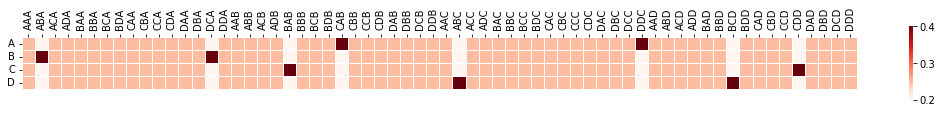

In [42]:
## Plot transition matrix:
    
pattern_size = 4
pseudo_seq = (
    "".join(seq) + "".join(seq[0:pattern_size-1])
)
trans_mat = compute_trans_mat(
    stim_list, pattern_size, pseudo_seq
)
plot_transition_mat(
    trans_mat, # .iloc[:, :15] for a suitablle readability
    show_dat=False, 
    fig_size=(15, 2)
)
for x in list(trans_mat.sum().round(3)):
    if x != 1:
        print(x) # make sure each column sums to one

In [43]:
## Compute information theoretic indices:
    
stim_stream = data_all["Target"].to_list() 
step = [block_size, section_len][1]

start_points = np.arange(0, len(stim_stream) - step + 1, step)
end_points = np.arange(step, len(stim_stream) + 1, step)

it_indices = [[], [], [], [], []]

for t0, t1 in zip(start_points, end_points):
    results = compute_IT_indices(
        stim_list, pattern_size, stim_stream[t0:t1]) 

    for x in range(5):
        it_indices[x].append(results[x])
        
DF = pd.DataFrame({
    "Index"    : data_all.index, 
    "Surprisal": sum(it_indices[0], []), 
    "Entropy"  : sum(it_indices[1], []), 
    "MI"       : sum(it_indices[3], []), 
    "IG"       : sum(it_indices[4], []), 
})
DF.set_index(["Index"], inplace=True)
DF = DF.loc[data_seqlearn.index, :]
DF["RT_imp"] = data_seqlearn["RT_imp"].copy()

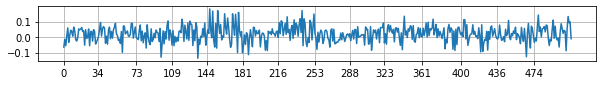

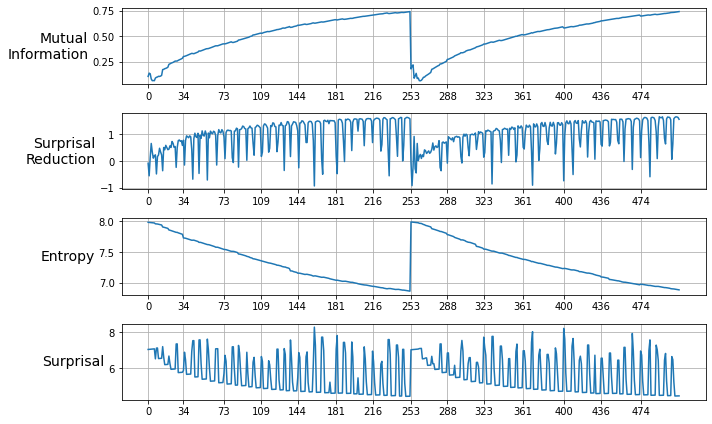

In [118]:
## Plot the results:

unit_size = n_trials * n_repeat
start = 0
end = DF.shape[0]

unit_nums, unit_begins = np.unique(
    np.array([ 
        n // unit_size 
        for n, x in enumerate(
            data_all.query("State == 'S' or State == 'Sequential'").index
        ) 
        if x in data_seqlearn[start:end].index
    ]), 
    return_index=True)

fig = plt.figure(figsize=(10, 1))
ax = fig.add_subplot()
plt.plot(np.arange(start, end, 1), DF["RT_imp"][start:end])
ax.set_xticks(unit_begins)
plt.grid()
plt.show()

plot_IT_indices(
    start, end, block_size=None, x_ticks=unit_begins, 
    track_surprisal=DF["Surprisal"][start:end], fid_s=414, 
    track_entropy=DF["Entropy"][start:end], fid_e=413, 
    track_mutual_info=DF["MI"][start:end], fid_mi=411, 
    track_sp_reduction=DF["IG"][start:end], fid_sr=412
)

In [ ]:
stim_stream = data["Target"].to_list() 

for t in range(1, len(stim_stream) + 1):

    observations = stim_stream[:t] 
    trans_mat = compute_trans_mat(stim_list, pattern_size, obsverations)
    
    

    ## Conditional Entropy:
    track_cond_entropy.append( 
        compute_conditional_entropy(p_joint, p_x_prev, p_x_curr))

In [ ]:
# vals, counts = np.unique(stim_stream[:1], return_counts=True)
# print(dict(zip(vals, (counts + 1) / (sum(counts) + 4) )))

## 5. Testing
Harrison, Duggins & Friston (2006) Encoding uncertainty in the hippocampus.
https://doi.org/10.1016/j.neunet.2005.11.002

In [ ]:
# stim_list = ["A", "B", "C", "D"]

In [ ]:
# ## A given transition matrix:

# A = np.array([
#     [0.6 , 0.3 , 0.1 , 0.35],
#     [0.1 , 0.05, 0.7 , 0.1 ],
#     [0.2 , 0.5 , 0.15, 0.4 ],
#     [0.1 , 0.15, 0.05, 0.15]
# ])
# trans_dict = { 
#     stim: dict(zip(stim_list, A.T[x])) 
#     for x, stim in enumerate(stim_list) 
# }
# plot_transition_mat(
#     pd.DataFrame.from_dict(trans_dict), 
#     c_map="Reds_r"
# )

In [ ]:
# ## Generate a stimuli stream based on the transition matrix:

# block_size = 40
# stream_len = block_size * 12

# stream = ["A", "B", "C", "D"] # initial 4 trials show each stimuli once
# np.random.shuffle(stream)     # in a random order
# TPs = [.25] * 4
# current_len = len(stream)

# while current_len <= stream_len:
#     stim = stim_list[np.random.choice(len(stim_list), p=TPs)]
#     stream.append(stim)
#     TPs = list(trans_dict[stim].values())
#     current_len += 1
    
#     ## Avoid the same stimulus appearing three times in a row:
#     if len(stream) >= 3 and stream[-1] == stream[-2] == stream[-3]:
#         stream.pop()
#         current_len -= 1
        
# # print("".join(stream))

In [ ]:
# ## Estimate transition matrix from the generated stimuli stream:

# estimated_trans_mat = compute_trans_mat(stim_list, 2, stream)
# plot_transition_mat(estimated_trans_mat, c_map="Reds_r") 

In [ ]:
# it_indices = [[], [], [], [], []]

# pattern_size = 2

# start_points = np.arange(0, stream_len - block_size + 1, block_size)
# end_points = np.arange(block_size, stream_len + 1, block_size)
    
# for t0, t1 in zip(start_points, end_points):
#     results = compute_IT_indices(stim_list, pattern_size, stream[t0:t1]) 
#         # initialize calculations at the beginning of each block
    
#     for x in range(5):
#         it_indices[x].append(results[x]) 

In [ ]:
# plot_IT_indices(0, stream_len, block_size, 
#                 fig_size=(10, 6), 
#                 track_surprisal=sum(it_indices[0], []), fid_s=414, 
#                 track_entropy=sum(it_indices[1], []), fid_e=413, 
#                 # track_cond_entropy=sum(it_indices[2], []), 
#                 track_mutual_info=sum(it_indices[3], []), fid_mi=411, 
#                 track_sp_reduction=sum(it_indices[4], []), fid_sr=412)